<a href="https://colab.research.google.com/github/dvanhuy11/AIO2023/blob/main/Resnet_with_CIFAR10_label_FULL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#import thư viện
import torch
import torchvision
import torch.nn as nn
import cv2
import os
import tensorflow
import torch.optim as optim
import torchvision.transforms as transforms
from torch.optim.swa_utils import AveragedModel
from torch.utils.data.sampler import SubsetRandomSampler    # Tách tập train và valid
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from typing import List, Type, Optional, Any, Union

In [ ]:
# # @Cài đặt dataset CIFAR10
# from torchvision import datasets
# data_path= '/content/drive/MyDrive/AIO/CODE/'
# cifar10 = datasets.CIFAR10(data_path, train = True, download = True)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
def data_loader(data_dir,
                batch_size=128,
                random_seed=42,
                valid_size=0.1,
                shuffle=True,
                test=False):
  normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                    std=[0.5, 0.5, 0.5])

  if test:
    transform = transforms.Compose([
      transforms.ToTensor(),                  #
      normalize,
    ])
    dataset = torchvision.datasets.CIFAR10(root=data_dir,
                                          train=False,
                                          download=True,
                                          transform=transform)

    test_loader = torch.utils.data.DataLoader(dataset,
                                            batch_size=batch_size,  #
                                            shuffle=False,          # không xáo trộn
                                            num_workers=2)
    return test_loader

  # Phép Augmentation
  transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),      #
    transforms.RandomCrop(32, padding=4),   #
    transforms.ToTensor(),                  #
    normalize,                              #
  ])

  # Lấy dataset
  train_dataset = torchvision.datasets.CIFAR10(root=data_dir,
                                        train=True,
                                        download=True,
                                        transform=transform)

  # Chỉ mục dữ liệu
  num_train = len(train_dataset)
  indices = list(range(num_train))
  split = int(np.floor(valid_size * num_train))

  # Xáo trộn chỉ mục
  if shuffle:
    np.random.seed(random_seed)
    np.random.shuffle(indices)

  # Chia tập train và valid theo chỉ mục
  train_idx, valid_idx = indices[split:], indices[:split]
  train_sampler = SubsetRandomSampler(train_idx)                  # ?
  valid_sampler = SubsetRandomSampler(valid_idx)                  # ?

  train_loader = torch.utils.data.DataLoader(train_dataset,       # Dataset
                                            sampler=train_sampler,
                                            batch_size=batch_size,
                                            num_workers=2)

  valid_loader = torch.utils.data.DataLoader(train_dataset,       # Dataset
                                            sampler=valid_sampler,
                                            batch_size=batch_size,
                                            num_workers=2)

  return (train_loader, valid_loader)

In [ ]:
data_dir = './data'
train_loader, valid_loader = data_loader(data_dir=data_dir)
test_loader = data_loader(data_dir=data_dir, test=True)

100%|██████████| 170498071/170498071 [00:12<00:00, 13253231.25it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
print(f'Num classes: {num_classes}')

Num classes: 10


In [ ]:
#định nghĩa và khởi tạo mạng Resnet
import torch.nn as nn
import math

def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)

        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()

        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * Bottleneck.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * Bottleneck.expansion)
        self.relu = nn.ReLU(inplace=True)

        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)
        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(self, depth, num_classes, bottleneck=False):
        super(ResNet, self).__init__()
        blocks ={18: BasicBlock, 34: BasicBlock, 50: Bottleneck, 101: Bottleneck, 152: Bottleneck, 200: Bottleneck}
        layers ={18: [2, 2, 2, 2], 34: [3, 4, 6, 3], 50: [3, 4, 6, 3], 101: [3, 4, 23, 3], 152: [3, 8, 36, 3], 200: [3, 24, 36, 3]}
        assert layers[depth], 'invalid detph for ResNet (depth should be one of 18, 34, 50, 101, 152, and 200)'

        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(p=0.8)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(blocks[depth], 64, layers[depth][0])
        self.layer2 = self._make_layer(blocks[depth], 128, layers[depth][1], stride=2)
        self.layer3 = self._make_layer(blocks[depth], 256, layers[depth][2], stride=2)
        self.layer4 = self._make_layer(blocks[depth], 512, layers[depth][3], stride=2)
        self.avgpool = nn.AvgPool2d(7)
        self.fc = nn.Linear(512 * blocks[depth].expansion, num_classes)

        for m in self.modules(): # duyệt qua các modules bao gồm các lớp con
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n)) # phân phối Gaussian
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
          # kiểm tra xem có cần giảm kích thước hoặc số lượng kênh đầu vào khác số lượng
          # kênh đầu ra mong muốn hay không
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        # x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        # x = F.normalize(x)
        x = self.fc(x)

        return x


In [ ]:

# # # Số classes trong CIFAR-10

# # Khởi tạo mô hình ResNet với kiến trúc 18 layers và số classes là 10
# model = ResNet(18, num_classes= num_classes).to(device)

# # Hàm mất mát và tối ưu hóa
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)


In [ ]:
# EPOCHS = 50

# # Với mỗi epoch
# losses = []                     #
# valid_acc = []
# test_acc = []
# for epoch in range(EPOCHS):
#     # running_loss = 0                #

#     # Với mỗi batch 128 ảnh
#     for i, inp in enumerate(train_loader):
#         inputs, labels = inp
#         inputs, labels = inputs.to(device), labels.to(device)

#         # Forward
#         outputs = model(inputs)
#         loss = criterion(outputs, labels) # Tính lỗi
#         losses.append(loss.item())

#         # Backward
#         optimizer.zero_grad()       # Đặt graident về 0
#         loss.backward()             # tính gradient
#         optimizer.step()            # cập nhật trọng số
#         del inputs, labels, outputs

#     print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, EPOCHS, losses[-1]))

#     with torch.no_grad():
#       # Validation
#       correct = 0
#       total = 0
#       for images, labels in valid_loader:
#         images = images.to(device)
#         labels = labels.to(device)
#         outputs = model(images)
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()
#       valid_acc.append(correct/total)

#       # Test
#       correct = 0
#       total = 0
#       for images, labels in test_loader:
#         images = images.to(device)
#         labels = labels.to(device)
#         outputs = model(images)
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()
#       test_acc.append(correct/total)

# print('Training Done')

In [ ]:
'''
    Function for computing the accuracy of the predictions over the entire data_loader
'''
def get_accuracy(model, data_loader, device):
    correct = 0
    total = 0

    with torch.no_grad():
        model.eval()
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100*(correct/total)

'''
    Function for plotting training and validation losses
'''
def plot_losses(train_acc, valid_acc, train_loss, valid_loss):
    # change the style of the plots to seaborn
    plt.style.use('seaborn')

    train_acc = np.array(train_acc)
    valid_acc = np.array(valid_acc)

    fig, (ax1, ax2) = plt.subplots(1, 2)

    ax1.plot(train_acc, color="blue", label="Train_acc")
    ax1.plot(valid_acc, color="red", label="Validation_acc")
    ax1.set(title="Acc over epochs",
            xlabel="Epoch",
            ylabel="Acc")
    ax1.legend()

    ax2.plot(train_loss, color="blue", label="Train_loss")
    ax2.plot(valid_loss, color="red", label="Validation_loss")
    ax2.set(title="loss over epochs",
            xlabel="Epoch",
            ylabel="Loss")
    ax2.legend()

    fig.show()

    # change the plot style to default
    plt.style.use('default')

'''
    function for the training step of the training loop
'''
def train(train_loader, model, criterion, optimizer, device):
    model.train()
    running_loss = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        # backward and optimizer
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = running_loss / len(train_loader)

    return model, optimizer, epoch_loss

'''
    function for the validation step of the training loop
'''
def validate(valid_loader, model, criterion, device):
    model.eval()
    running_loss = 0

    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)

        # forward pass and record loss
        outputs = model(images)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

    epoch_loss = running_loss / len(valid_loader)

    return model, epoch_loss

'''
    function defining the entire training loop
'''
def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
    if not os.path.exists("save_model"):
      os.mkdir("save_model")
    # set object for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
    list_train_acc = []
    list_val_acc = []

    # train model
    for epoch in range(0, epochs):
        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)

        if epoch % print_every == print_every - 1:
            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)


            print('Epochs: {}, Train_loss: {}, Valid_loss: {}, Train_accuracy: {}, Valid_accuracy: {}'.format(
                    epoch, train_loss, valid_loss, train_acc, valid_acc
                    ))

            list_train_acc.append(train_acc)
            list_val_acc.append(valid_acc)
            train_losses.append(train_loss)
            valid_losses.append(valid_loss)

            # save model
            torch.save(model.state_dict(), "save_model/epoch_{}_acc{}.pth".format(epoch, valid_acc))
            print("[INFO] save_model/epoch_{}_acc{}.pth".format(epoch, valid_acc))

    plot_losses(list_train_acc, list_val_acc, train_losses, valid_losses)

    return model, optimizer, (train_losses, valid_losses)

In [ ]:
model = ResNet(18, 10).to(device)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
loss_function = nn.CrossEntropyLoss()

Epochs: 0, Train_loss: 1.5727771822024474, Valid_loss: 3.3597924015190026, Train_accuracy: 16.315555555555555, Valid_accuracy: 17.5
[INFO] save_model/epoch_0_acc17.5.pth
Epochs: 1, Train_loss: 1.439565065570853, Valid_loss: 2.975504513028302, Train_accuracy: 17.671111111111113, Valid_accuracy: 18.77
[INFO] save_model/epoch_1_acc18.77.pth
Epochs: 2, Train_loss: 1.3553521975197576, Valid_loss: 2.6373956475076796, Train_accuracy: 23.10888888888889, Valid_accuracy: 25.03
[INFO] save_model/epoch_2_acc25.03.pth
Epochs: 3, Train_loss: 1.2859230116009712, Valid_loss: 2.8584429161458074, Train_accuracy: 23.288888888888888, Valid_accuracy: 24.65
[INFO] save_model/epoch_3_acc24.65.pth
Epochs: 4, Train_loss: 1.2265263071114367, Valid_loss: 2.6834089756011963, Train_accuracy: 26.700000000000003, Valid_accuracy: 28.74
[INFO] save_model/epoch_4_acc28.74.pth
Epochs: 5, Train_loss: 1.174828478050503, Valid_loss: 2.755738892132723, Train_accuracy: 27.54, Valid_accuracy: 30.59
[INFO] save_model/epoch_5_a

<ipython-input-13-d88bfa2d5d25>:27: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


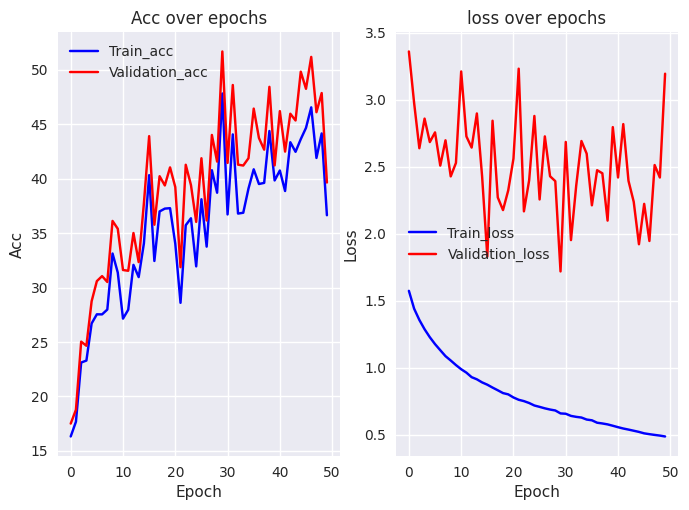

In [ ]:
model, optimizer, _ = training_loop(model, loss_function, optimizer, train_loader, test_loader, 50, device)